1. Write a python class called `ProcessGameState` that will accomplish the following:<br>
   a. Handle file ingestion and ETL (if deemed necessary)<br>
   b. Return whether or not each row falls within a provided boundary<br>
     i. Be as efficient as possible (minimize runtime)<br>
     ii. Reduce dependencies outside of standard Python libraries.<br>
   c. Extract the weapon classes from the inventory json column

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.path as mpath

class ProcessGameState:
    def __init__(self, file_path, boundary, z_boundary):
        self.data = pq.read_table(file_path).to_pandas()
        self.boundary = mpath.Path(boundary)
        self.z_bounds = z_boundary
        #Map each row to whether or not it is in the boundary
        self.rows_in_boundary = {}
        #Map each row to whether or not it has two Rifles or SMGs
        self.weapons = {}
    
    #O(N * V) where N is every xyz of every row and V is the number of boundary coords
    def is_within_boundary(self):
        
        for index, row in self.data.iterrows():
            x = row["x"]
            y = row["y"]
            z = row["z"]
            
            if self.boundary.contains_point([x, y]) and self.z_bounds[0] <= z <= self.z_bounds[1]:
                self.rows_in_boundary[index] = True
            else:
                self.rows_in_boundary[index] = False
                
                
    #O(N) where N is every item in every players inventory          
    def two_weapons(self):
        for i, inventory in enumerate(self.data["inventory"]):
            #Go through every weapon
            if inventory is not None:
                has_two = 0
                for item in inventory:
                    if item["weapon_class"] == "Rifle" or item["weapon_class"] == "SMG":
                        has_two += 1
                if has_two >= 2:
                    self.weapons[i] = True
                    continue
            self.weapons[i] = False

2. Using the created class, answer the following questions:<br>
   a. Is entering via the light blue boundary a common strategy used by Team2 on T (terrorist) side?<br>
   b. What is the average timer that Team2 on T (terrorist) side enters "BombsiteB" with at least 2 rifles or SMGs?<br>
   c. Now that we've gathered data on Team2 T side, let's examine their CT (counter-terrorist) Side. Using the same data set, tell our coaching staff where you suspect them to be waiting inside "BombsiteB"<br>


In [2]:
file_path = "game_state_frame_data.parquet"
sample_bounds = [[-1735, 250], [-2024, 398], [-2806, 742], [-2472, 1233], [-1565, 580]]
sample_z_bounds = [285, 421]


solution = ProcessGameState(file_path, sample_bounds, sample_z_bounds)
solution.is_within_boundary()
solution.two_weapons()

In [3]:
#(a)
filtered_data = solution.data[(solution.data["team"] == "Team2") & (solution.data["side"] == "T")]

total_time_in_boundary = 0
total_time_in_game = 0

for index, row in filtered_data.iterrows():
    if solution.rows_in_boundary[index] == True:
        total_time_in_boundary += 1
    total_time_in_game += 1

print(total_time_in_boundary/total_time_in_game)

0.00034602076124567473


We can see in this data that Team2 only enters via the light blue boundary when they are on the terrorist side 0.0346% of the time so it is NOT a common strategy.

In [4]:
#(b)

def convert_minutes_to_seconds(minutes):
    minutes_split = minutes.split(":")
    minutes = int(minutes_split[0])
    seconds = int(minutes_split[1])
    total_seconds = minutes * 60 + seconds
    return total_seconds


timer = 0
samples = 0

for index, row in filtered_data.iterrows():
    if row["area_name"] == "BombsiteB" and solution.weapons[index] == True:
        timer += convert_minutes_to_seconds(row["clock_time"])
        samples += 1

print(timer)
print(samples)

0
0


We can see that there are zero samples where Team2 on Terrorist side enters BombsiteB with 2 rifles or SMGs.

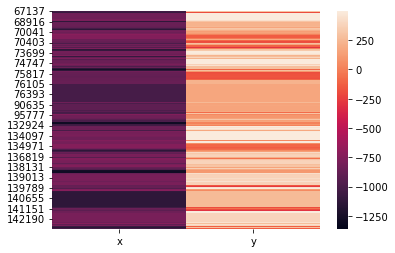

-828
484


In [5]:
#(c)
import numpy as np
import seaborn as sns
from scipy.stats import kde
import matplotlib.pyplot as plt

ct_data = solution.data[(solution.data["team"] == "Team2")
                        & (solution.data["side"] == "CT")
                        & (solution.data["area_name"] == "BombsiteB")]

heatmap = sns.heatmap(ct_data[["x", "y"]])

plt.show()

x = ct_data["x"].values
y = ct_data["y"].values

k = kde.gaussian_kde(np.vstack([x, y]))
density = k(np.vstack([x, y]))

max_density_index = np.argmax(density)

x_max_density = x[max_density_index]
y_max_density = y[max_density_index]

print(x_max_density)
print(y_max_density)


We can see that the points are concentrated mostly arround (-828, 484) so that is probably where they are waiting inside.

3. (No Coding) Most of the time, our stakeholders (in this case, the CS:GO coaching staff) aren’t tech-savvy enough to run code themselves. Propose a solution to your product manager that:<br> a. could allow our coaching staff to request or acquire the output themselves<br> b. takes less than 1 weeks worth of work to implement<br>

One way for the coaching staff to see if entering via the light blue boundary is a common strategy used by Team2 on Terrorist side is to look at the rounds where Team2 is on Terrorist side and record how many times they enter from the blue boundary. Then, we can divide that by the total number of rounds played and that will show how frequently it happens. (close to 0 = not very frequent, close to 1 = frequent) We can see the average timer that Team2 on T enters BombsiteB with at least 2 rifles or SMGs the similarly by recording the timestamp every time they get to BombsiteB with at least 2 rifles or SMGS, summing the time after converting it to seconds, and dividing that by the total number of occurences. FInally we can try to find out where to expect them to be hiding by getting the x, y positions of the players over some games and looking at the frequency of where they stand in each game.